In [1]:
import sys
import os

sys.path.append('../../')

import keras_tuner as kt
from keras.callbacks import EarlyStopping
from src.dataset import *
from src.hypermodels import *
from src.utils import *
import keras.backend as K
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend


# Define Hyperparams Search Space

In [2]:
def build_model(hp):
    # Hyperparameters of model architecture
    img_size = 224 # VGG19 input size
    
    feature_extractor = hp.Fixed('feature_extractor', value='vgg19')
    
    num_dense_layers = hp.Int('num_dense_layers', min_value=2, max_value=4, step=1, default=2)
    dense_units_list = [hp.Int(f'dense_units_{i + 1}', min_value=16, max_value=96, step=16, default=64)
                        for i in range(num_dense_layers)]
    dense_activation_list = [hp.Choice(f'dense_activation_{i + 1}', values=['relu', 'tanh', 'linear','sigmoid'],default='relu')
                             for i in range(num_dense_layers)]
    dropout_rate_list = [hp.Float(f'dropout_rate_{i + 1}', min_value=0.3, max_value=0.6, step=0.1, default=0.4)
                         for i in range(num_dense_layers)]
    ranking_score_activation = hp.Choice('ranking_score_activation', values=['tanh', 'linear'])
    unfreeze_layers = hp.Int('unfreeze_layers', min_value=0, max_value=4, step=1, default=4)
    final_activation = hp.Fixed('final_activation', value='sigmoid')
    

    image_preprocessing_layers = Sequential(
        [
            layers.Resizing(height=img_size, width=img_size),
            layers.Rescaling(scale=1. / 255)
        ],
        name='image_preprocessing'
    )

    image_augmentation_layers = Sequential(
        [
            layers.RandomRotation(factor=0.2),
            layers.RandomFlip(),
            layers.RandomContrast(factor=0.4),
            layers.RandomZoom(height_factor=0.3, width_factor=0.3),
            layers.RandomBrightness(factor=0.4)
        ],  
        name='image_augmentation'
    )
    

    # Build the model
    meta_model = create_siamese_network(
        img_size, image_preprocessing_layers, image_augmentation_layers,
        feature_extractor, num_dense_layers, dense_units_list, dense_activation_list,
        dropout_rate_list,
        ranking_score_activation, final_activation,
        pretrained_weights='imagenet',
        unfreeze_layers=unfreeze_layers,
    )

    # Hyperparameters of model training
    optimizers = {
        'adam': Adam(learning_rate=hp.Choice('learning_rate', values=[1e-5, 1e-4])),
        'rmsprop': RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-5, 1e-4]))
    }

    meta_model.compile(optimizer=optimizers[hp.Choice('optimizer', values=['adam', 'rmsprop'])],
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    return meta_model

build_model(kt.HyperParameters())

# Define Tuner

In [3]:
from datetime import date, datetime
# Set the seed for data shuffling based on date and time
r_today = date.today().strftime("%y%m%d")
r_time = datetime.now().strftime("%H%M")
r_datetime = int(f'{r_today}{r_time}')
print('execute_time: ', r_datetime)

hypermodel_tuning_dir = 'hypermodel_tuning/BayesianOptimization_Q4_Datasets_rs2310111018'
project_name = "BayesianOptimization_{}".format(r_datetime)

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=100,
    # num_initial_points=None,
    # alpha=0.0001,
    # beta=2.6,
    # seed=None,
    # hyperparameters=None,
    # tune_new_entries=True,
    # allow_new_entries=True,
    # max_retries_per_trial=0,
    # max_consecutive_failed_trials=3,
    overwrite=False,
    directory=hypermodel_tuning_dir,
    project_name=project_name,
)

tuner.search_space_summary()

execute_time:  2310111058
Search space summary
Default search space size: 13
feature_extractor (Fixed)
{'conditions': [], 'value': 'vgg19'}
num_dense_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': 64, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'linear', 'sigmoid'], 'ordered': False}
dense_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'linear', 'sigmoid'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.3, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.3, 'max_value': 0.6, 'step'

# Data Preparation

In [4]:
# question_id = 2
# 
# duel_results_path = f'../../data/duel_results/duels_question_{question_id}.csv'
# image_file_dir = '../../data/Mapillary_data/Sample_web_green'
# 
# print(f'Dataset Seed:{data_shuffle_seed}') # For reproducibility, seed is defined using the date and time (e.g. 2021-01-01 12:30:15 -> seed = 20210101123015)
# image_size = 224 
# (x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(duel_results_path, 
#                                                                        image_file_dir, 
#                                                                        img_size=image_size,
#                                                                        model_type='ranking',
#                                                                        shuffle=True, 
#                                                                        shuffle_seed=data_shuffle_seed)


# Load from the saved numpy arrays
x1_train,x2_train = np.load('../../data/Q4_Datasets_rs2310111018/x_train.npy')
x1_val,x2_val = np.load('../../data/Q4_Datasets_rs2310111018/x_val.npy')
x1_test,x2_test = np.load('../../data/Q4_Datasets_rs2310111018/x_test.npy')

y_train = np.load('../../data/Q4_Datasets_rs2310111018/y_train.npy')
y_val = np.load('../../data/Q4_Datasets_rs2310111018/y_val.npy')
y_test = np.load('../../data/Q4_Datasets_rs2310111018/y_test.npy')


x_train = [x1_train, x2_train]
x_val = [x1_val, x2_val]
x_test = [x1_test, x2_test]

del x1_train,x2_train,x1_val,x2_val,x1_test,x2_test

# Start Searching

In [8]:
tuner.search(x=x_train,
             y=y_train,
             epochs=50,
             batch_size=32,
             validation_data=(x_val, y_val),
             callbacks=[EarlyStopping(monitor='val_accuracy', 
                                      patience=10, 
                                      baseline=0.66,
                                      restore_best_weights=True)])

# Print the Search Space

In [9]:
tuner.search_space_summary()

project_dir = f'{hypermodel_tuning_dir}/{project_name}'
os.makedirs(project_dir, exist_ok=True)

with open(f'{project_dir}/search_space.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.search_space_summary()))
    sys.stdout = original_stdout
    f.close()


Search space summary
Default search space size: 19
feature_extractor (Fixed)
{'conditions': [], 'value': 'vgg19'}
num_dense_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': 64, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'linear', 'sigmoid'], 'ordered': False}
dense_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'linear', 'sigmoid'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.3, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.3, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear

# Query the Search Results

In [10]:
tuner.results_summary()

with open(f'{project_dir}/results_summary.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.results_summary()))
    sys.stdout = original_stdout
    f.close()

Results summary
Results in hypermodel_tuning/BayesianOptimization_Q4_Datasets_rs2310111018\BayesianOptimization_2310111058
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 036 summary
Hyperparameters:
feature_extractor: vgg19
num_dense_layers: 4
dense_units_1: 96
dense_units_2: 32
dense_activation_1: relu
dense_activation_2: sigmoid
dropout_rate_1: 0.4
dropout_rate_2: 0.4
ranking_score_activation: tanh
unfreeze_layers: 2
final_activation: sigmoid
learning_rate: 1e-05
optimizer: rmsprop
dense_units_3: 80
dense_activation_3: linear
dropout_rate_3: 0.4
dense_units_4: 64
dense_activation_4: sigmoid
dropout_rate_4: 0.3
Score: 0.697752833366394

Trial 006 summary
Hyperparameters:
feature_extractor: vgg19
num_dense_layers: 3
dense_units_1: 80
dense_units_2: 64
dense_activation_1: linear
dense_activation_2: relu
dropout_rate_1: 0.3
dropout_rate_2: 0.3
ranking_score_activation: tanh
unfreeze_layers: 0
final_activation: sigmoid
learning_rate: 1e-05
optimizer: adam
de

# Save the best models with weights, hyperparameters defined in the search space and model architectures 

In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=10)
best_models = tuner.get_best_models(num_models=10)

import json
for i in range(len(best_models)):
    # save the weighted models 
    best_models[i].save(f'{project_dir}/best_model_{i+1}.keras')
    
    # save the hyperparameters defined in the search space
    with open(f'{project_dir}/best_hps_{i+1}.json', 'w') as f:
        json.dump(best_hps[i].values, f, indent=4)
    
    # save the model architecture
    best_model_architecture = build_model(best_hps[i])
    with open(f'{project_dir}/best_model_architecture_{i+1}.json', 'w') as f:
        f.write(best_model_architecture.to_json(indent=4))
        f.close()

# Retrain the best models

Retraining Model 1...
Epoch 1/50
84/84 [==============================] - 9s 91ms/step - loss: 0.7854 - accuracy: 0.5208 - val_loss: 0.6850 - val_accuracy: 0.5618
Epoch 2/50
84/84 [==============================] - 7s 86ms/step - loss: 0.7675 - accuracy: 0.5447 - val_loss: 0.6719 - val_accuracy: 0.5966
Epoch 3/50
84/84 [==============================] - 7s 86ms/step - loss: 0.7320 - accuracy: 0.5728 - val_loss: 0.6702 - val_accuracy: 0.6045
Epoch 4/50
84/84 [==============================] - 7s 86ms/step - loss: 0.7090 - accuracy: 0.5912 - val_loss: 0.6563 - val_accuracy: 0.6236
Epoch 5/50
84/84 [==============================] - 7s 86ms/step - loss: 0.6844 - accuracy: 0.6140 - val_loss: 0.6495 - val_accuracy: 0.6449
Epoch 6/50
84/84 [==============================] - 7s 86ms/step - loss: 0.6614 - accuracy: 0.6335 - val_loss: 0.6499 - val_accuracy: 0.6494
Epoch 7/50
84/84 [==============================] - 7s 87ms/step - loss: 0.6794 - accuracy: 0.6196 - val_loss: 0.6455 - val_accuracy

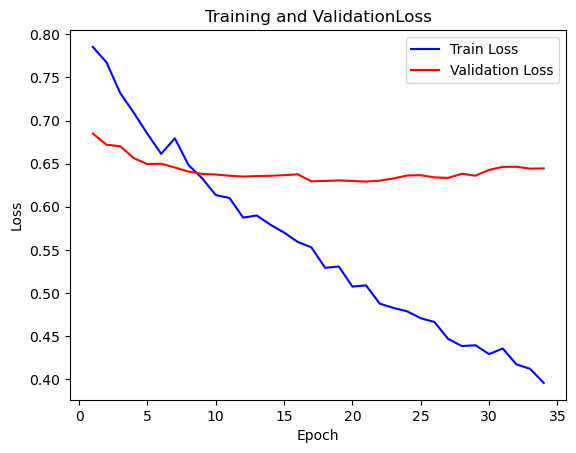

Figure Training and ValidationAccuracy saved!


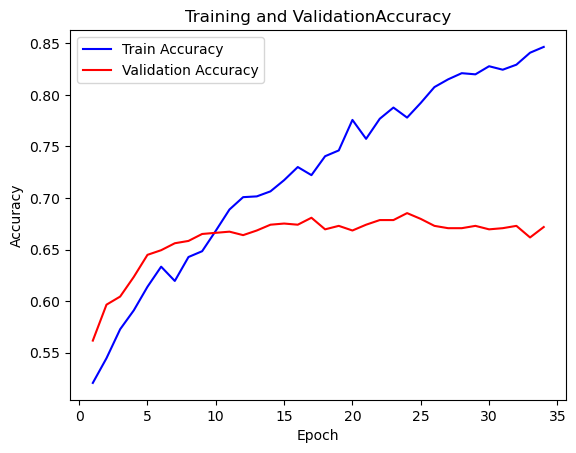

Model 1 training results saved.
Retraining Model 2...
Epoch 1/50
84/84 [==============================] - 21s 235ms/step - loss: 0.7669 - accuracy: 0.5406 - val_loss: 0.7311 - val_accuracy: 0.5640
Epoch 2/50
84/84 [==============================] - 19s 230ms/step - loss: 0.7161 - accuracy: 0.5975 - val_loss: 0.6863 - val_accuracy: 0.6180
Epoch 3/50
84/84 [==============================] - 19s 230ms/step - loss: 0.6935 - accuracy: 0.5979 - val_loss: 0.6904 - val_accuracy: 0.6112
Epoch 4/50
84/84 [==============================] - 19s 230ms/step - loss: 0.6781 - accuracy: 0.6177 - val_loss: 0.6717 - val_accuracy: 0.6236
Epoch 5/50
84/84 [==============================] - 19s 230ms/step - loss: 0.6513 - accuracy: 0.6391 - val_loss: 0.6478 - val_accuracy: 0.6573
Epoch 6/50
84/84 [==============================] - 19s 230ms/step - loss: 0.6388 - accuracy: 0.6619 - val_loss: 0.6282 - val_accuracy: 0.6640
Epoch 7/50
84/84 [==============================] - 19s 229ms/step - loss: 0.6192 - accu

In [ ]:

for i in range(len(best_models)):
    print('Retraining Model {}...'.format(i+1))
    
    model = build_model(best_hps[i])
    
    # Train the model
    history = model.fit(x=x_train, 
              y=y_train, 
              batch_size=32, 
              epochs=50, 
              verbose=1, 
              callbacks=[EarlyStopping(monitor='val_accuracy', 
                                       patience=10, 
                                       baseline=0.6,
                                       restore_best_weights=True)],
              validation_data=(x_val, y_val))
    
    best_val_acc = max(history.history['val_accuracy'])
    
    model_save_dir = '{}/Model_{}_Ranking_VGG19_BestValAcc{:.4f}'.format(project_dir, i+1, best_val_acc)
    
    safe_save_training_results(hyperparams_dict=best_hps[i].values,
                               model=model,
                               model_save_type='keras', 
                               history=history, 
                               his_save_type='csv', 
                               save_dir = model_save_dir,)
    
    # Save the plot
    plot_model_metrics(history, ['loss', 'accuracy'], save_dir=model_save_dir)
    
    print('Model {} training results saved.'.format(i+1))
    
    # Clear the session for the next model
    K.clear_session()